This notebook generates some intermediate data data that are subsequently used in the notebook `analyze_clusters.ipynb`. Moreover, it has been used to create Supplementary Figures 20-21.

Contact:

- Paweł Szczerbiak: p.szczerbiak@gmail.com

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import networkx as nx

from pathlib import Path
from skbio.stats.composition import clr
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, fcluster

---
# Globals
---

In [2]:
MAIN_PATH = Path('./')  # current notebook directory
INPUT_PATH = MAIN_PATH / '..' / 'data' 

**NOTE:** `NetworkX` akgorithm for graph creation is non-deterministic. In order to get exactly the same results as presented in the paper, we suggest to use the data stored in the repo and select `COMPUTE_NX = False`

In [3]:
PSEUDOCOUNT = 1  # pseudocount used for clr transformation
COMPUTE_RHO = False  # whether to compute proportionality
COMPUTE_HC  = False  # whether to compute hierarchical clusters
COMPUTE_NX  = False  # whether to compute networkx graphs

---
# Load data
---

In [4]:
dnames = ['male', 'female', 'donorA', 'donorB']

### Raw data

In [5]:
interpolated_df = {}
for dname in dnames:
    filename = INPUT_PATH / 'first_interpolation_files' / f'{dname}_pchip_interpolated.tsv'
    interpolated_df[dname] = pd.read_csv(filename, delimiter='\t', index_col=0).T

### Rarefied data

In [6]:
rarefied_df = {}
for dname in dnames:
    filename = INPUT_PATH / 'ready_files' / f'{dname}_rarefied_18000_interpolated_pchip.tsv'
    rarefied_df[dname] = pd.read_csv(filename,  index_col=0, delimiter='\t').T

### Consider 150 days for `DonorB`

In [7]:
interpolated_df['donorB'] = interpolated_df['donorB'].iloc[:150] 
interpolated_df['donorB'] = interpolated_df['donorB'].loc[:, interpolated_df['donorB'].sum(axis=0) > 0]
rarefied_df[f'donorB'] = rarefied_df[f'donorB'].iloc[:150]
rarefied_df[f'donorB'] = rarefied_df[f'donorB'].loc[:,  rarefied_df['donorB'].sum(axis=0) > 0]

### Features

In [8]:
features = pd.read_csv(INPUT_PATH / 'ts_charactericstics_tables' /\
                       'LONGITUDINAL_CHARACTERISTICS_DF.csv', index_col=0)
features = features.reset_index()
features = features.rename(columns={'feature': 'subject_index',
                                   'white_noise_binary': 'white_noise'})
# Groups
features_gr = features.groupby('subject')    
features_gr = {dname: features_gr.get_group(dname).set_index('subject_index') for dname in dnames}

In [9]:
for dname in dnames:
    print(dname, features_gr[dname].shape, interpolated_df[dname].shape, features_gr[dname].loc[features_gr[dname].index.isin(interpolated_df[dname].columns)].shape )

male (1253, 51) (443, 1399) (1253, 51)
female (551, 51) (185, 591) (551, 51)
donorA (1524, 51) (365, 2862) (1524, 51)
donorB (1005, 51) (150, 1524) (1005, 51)


---
# Compute proportionality
---

## Compute `clr`

In [10]:
clr_df = {}
for dname in dnames:
    clr_df[dname] = pd.DataFrame(clr(interpolated_df[dname] + PSEUDOCOUNT), 
                                 columns=interpolated_df[dname].columns)
    clr_df[dname].to_csv(MAIN_PATH / f'intermediate/{dname}_clr.csv')

## Compute or load $\rho$

- $\rho$ is computed at lag = 0
- computation might take several minutes

In [11]:
def rho_corr(x, y):
    ''' Reference: 
            Erb and Notredame, 2016
        Inputs:
            x, y - numpy arrays (clr-transformed data)
        Outputs:
            proportionality(x, y)
    '''
    return 1 - np.var(x - y) / (np.var(x) + np.var(y))

In [12]:
if COMPUTE_RHO:
    rho_res = {}
    for k in clr_df.keys():
        print(f"\n{k}")
        cols = clr_df[k].columns
        res = np.zeros((len(cols), len(cols)))
        # compare all columns against all
        for i, col1 in enumerate(cols):
            for j, col2 in enumerate(cols):
                res[i, j] = rho_corr(clr_df[k][col1].values, 
                                     clr_df[k][col2].values)
            print(f"Done: {i+1} / {len(cols)}", end='\r')
        rho_res[k] = np.nan_to_num(res)  # replace NaNs with zeros
    np.save(MAIN_PATH / 'intermediate' / f'rho_res.npy', rho_res)
else:
    rho_res = np.load(MAIN_PATH / 'intermediate' / f'rho_res.npy', allow_pickle=True)[()]

---
# Hierarchical clusters
---

In [13]:
hc_method = 'complete'
hc_height = 2
cut_method = 'cut_tree'  # or 'fcluster'

## Load hierarchical clusters

In [14]:
if not COMPUTE_HC:
    clusters_gr = pd.read_pickle(open(MAIN_PATH / 'intermediate' / f'hclusters__{hc_method}-{hc_height}-{cut_method}.pkl', 'rb'))

## Create linkage

NOTE: Proportionality matrix is treated as matrix of features

In [15]:
if COMPUTE_HC:
    linkages  = {}
    dendrograms = {}
    for dname in dnames:
        linkages[dname] = linkage(rho_res[dname], method=hc_method)
        dendrograms[dname] = dendrogram(linkages[dname], no_labels=True)
        plt.title(f"Dataset: {dname}, hier. clust., method: {hc_method}")
        plt.show()

## Cut tree

In [16]:
if COMPUTE_HC:
    for dname in dnames:
        dendro_max = max([el[-2] for el in dendrograms[dname]['dcoord']])
        n_clusters = [cut_tree(linkages[dname], height=h).max() for h in np.arange(0, dendro_max)]
        plt.plot(n_clusters, label=dname)
    plt.yscale('log')
    plt.xlabel('Cut height')
    plt.ylabel('Number of clusters')
    plt.legend()
    plt.grid();

In [17]:
if COMPUTE_HC:
    clusters = {}
    for dname in dnames:
        if cut_method =='cut_tree':
            #  Flat clusters based on tree cut
            clusters[dname] = cut_tree(linkages[dname], height=hc_height).squeeze()
        elif  cut_method == 'fcluster':
            # Flat clusters based on inconsistency
            clusters[dname] = fcluster(linkages[dname], 0.8)
        else:
            raise ValueError

## Assign clusters to species

In [18]:
if COMPUTE_HC:
    clusters_gr = {}
    for dname in dnames:
        clusters_gr[dname] = pd.DataFrame(data={'species': clr_df[dname].columns, 
                                                'cluster': clusters[dname]})
        # Group species based on clusters
        clusters_gr[dname] = clusters_gr[dname].groupby('cluster').agg([len, list]).\
        sort_values(('species',  'len'), ascending=False)
        clusters_gr[dname].columns = clusters_gr[dname].columns.droplevel(0)
        clusters_gr[dname] = clusters_gr[dname].rename(columns={'len': 'length', 'list': 'species'})

## Compare cluster sizes

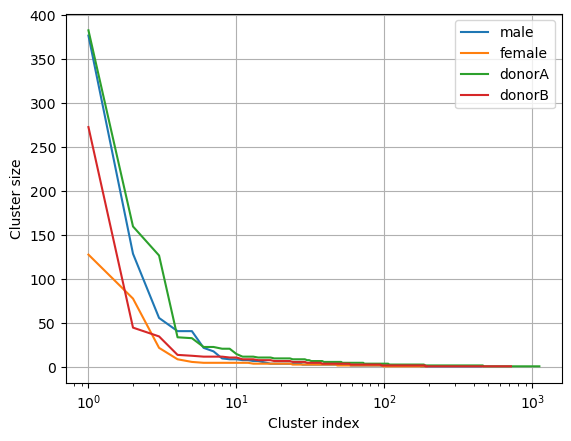

In [19]:
for dname in dnames:
    dat = clusters_gr[dname]['length'].sort_values(ascending=False).reset_index(drop=True)
    dat.index += 1
    dat.plot(label=dname)
plt.xlabel('Cluster index')
plt.ylabel('Cluster size')
plt.legend()
plt.xscale('log')
plt.grid();

## Compute statistics

In [20]:
if COMPUTE_HC:
    for dname in dnames:
        # consider only bacteria in rarefied dataframe
        rar_df = pd.DataFrame(columns=['species', 'length', 'mean_abund',
                                      'mean_rho', 'std_rho', 'median_rho'])
        for i, cols in clusters_gr[dname].iterrows():
            clusters_gr[dname].loc[i, 'mean_abund'] = interpolated_df[dname][cols.species].mean().mean()
            bacts = list(set(cols['species']) & set(rarefied_df[dname].columns))
            rar_df.loc[i, 'species'] = bacts
            rar_df.loc[i, 'length'] = len(bacts)
            rar_df.loc[i, 'mean_abund'] = rarefied_df[dname][bacts].mean().mean()
            # compute mean / std / median proportionality
            if len(bacts) > 1:    
                col_idx = [clr_df[dname].columns.get_loc(col) for col in bacts]
                cluster_arr = rho_res[dname][col_idx, :][:, col_idx]
                # remove diagonal (ones)
                cluster_arr = cluster_arr[~np.eye(cluster_arr.shape[0],dtype=bool)].reshape(-1)
                rar_df.loc[i, 'mean_rho'] = np.mean(cluster_arr)
                rar_df.loc[i, 'std_rho'] = np.std(cluster_arr)
                rar_df.loc[i, 'median_rho'] = np.median(cluster_arr)
        rar_df = rar_df.rename(columns=dict(zip(rar_df.columns, 
                                                [c + '_rar' for c in rar_df.columns])))
        clusters_gr[dname] = clusters_gr[dname].join(rar_df)

## Compare species abundance

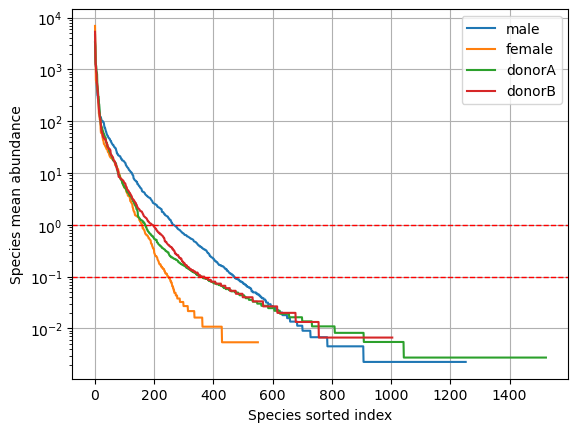

In [21]:
for dname in dnames:
    plt.plot(sorted(rarefied_df[dname].mean().values)[::-1], label=dname)
    # plt.plot(sorted(interpolated_df[dname].mean().values)[::-1], label=dname)
plt.axhline(y=1,  color='r', linestyle='--', linewidth=1)
plt.axhline(y=0.1,  color='r', linestyle='--', linewidth=1)
plt.yscale('log')
plt.legend()
plt.xlabel('Species sorted index')
plt.ylabel('Species mean abundance')
plt.grid();

## Construct abundant clusters

In [22]:
thr_clu = 0.1
clusters_gr_thr = {}
for dname in dnames:
    clusters_gr_thr[dname] = clusters_gr[dname][clusters_gr[dname].mean_abund_rar >= thr_clu]

## Species in time

In [23]:
idx_to_show = 0
x_span, y_span = 2, int(np.ceil(len(dnames) / 2))  # rows / columns span in plots

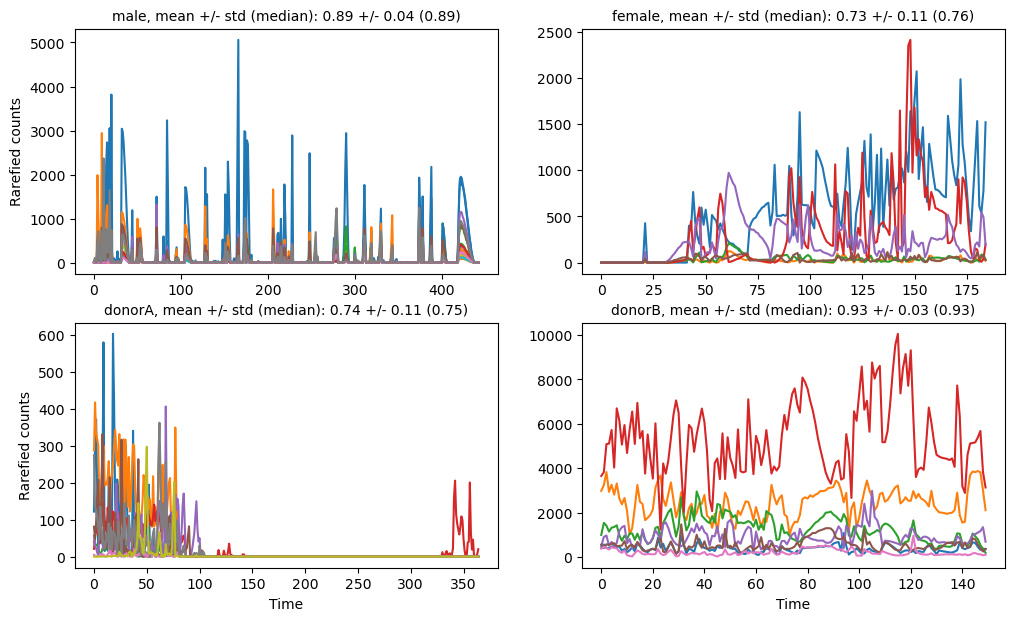

In [24]:
plt.figure(figsize=(12, 7))
for i in range(x_span):
    for j in range(y_span):
        idx = i*2 + j
        dname = dnames[idx]
        dat = clusters_gr_thr[dname].iloc[idx_to_show]
        plt.subplot(x_span, y_span, idx+1)
        plt.plot(rarefied_df[dname].loc[:, dat.species_rar].values)
        plt.title(f"{dname}, mean +/- std (median): {dat.mean_rho_rar:.2f} "
                  f"+/- {dat.std_rho_rar:.2f} ({dat.median_rho_rar:.2f})", fontsize=10)
        if i == x_span-1:
            plt.xlabel('Time')
        if j == 0:
            plt.ylabel('Rarefied counts')

## Supplementary Figure 20

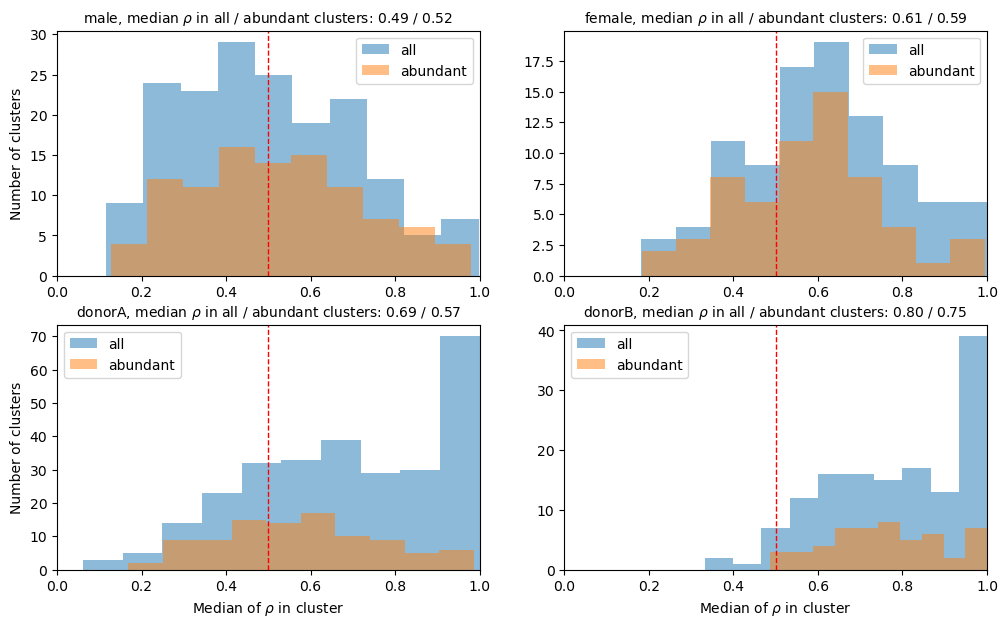

In [25]:
plt.figure(figsize=(12, 7))
for i in range(x_span):
    for j in range(y_span):
        idx = i*2 + j
        dname = dnames[idx]
        plt.subplot(x_span, y_span, idx+1)
        dat_all = clusters_gr[dname].median_rho_rar.dropna()
        dat_abund = clusters_gr_thr[dname].median_rho_rar.dropna()
        plt.hist(dat_all, alpha=0.5, label=f'all')
        plt.hist(dat_abund, alpha=0.5, label=f'abundant')
        plt.axvline(x=.5,  color='r', linestyle='--', linewidth=1)
        plt.xlim([0, 1])
        plt.legend()
        plt.title(f"{dname}, median " + r"$\rho$" + " in all / abundant clusters: "
                  f"{dat_all.median():.2f} / {dat_abund.median():.2f}", fontsize=10)
        if i == x_span-1:
            plt.xlabel(r'Median of $\rho$ in cluster')
        if j == 0:
            plt.ylabel('Number of clusters')
plt.savefig(MAIN_PATH / 'output' / 'hc' / 'hc_bar.png', dpi=400, bbox_inches='tight')

## Supplementary Figure 21

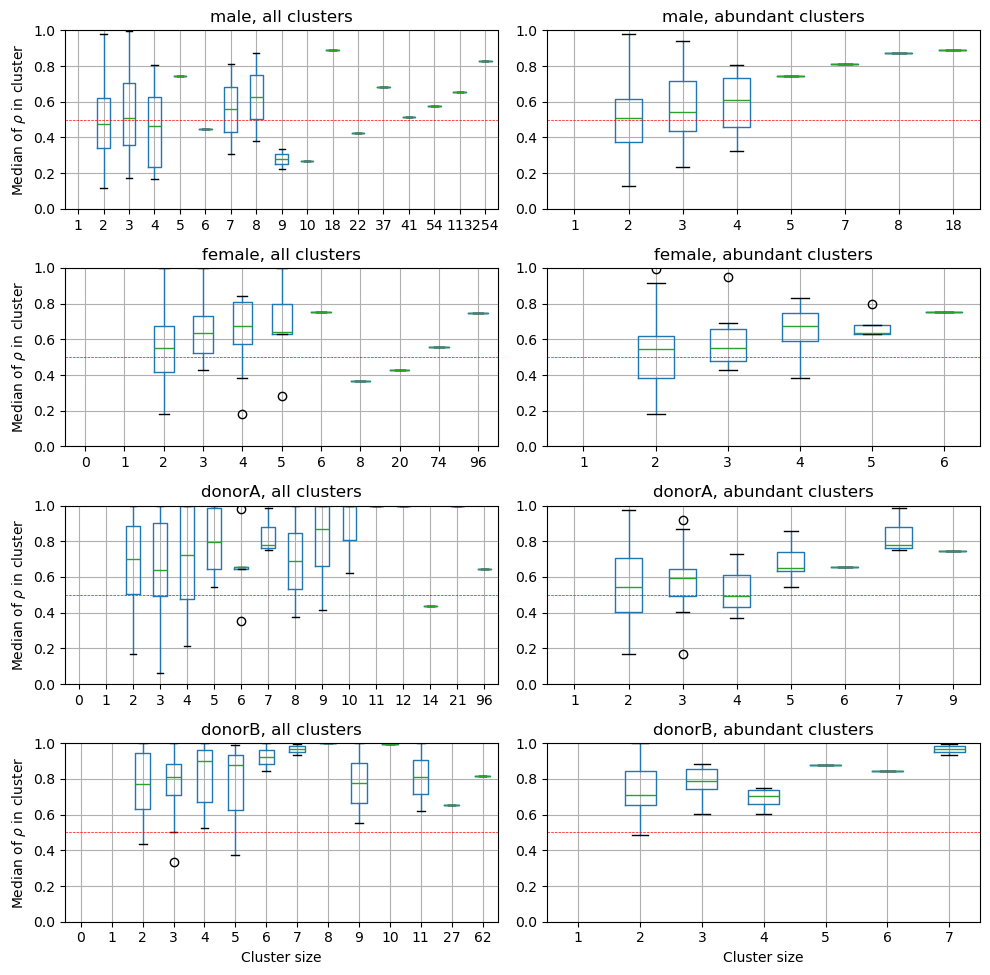

In [26]:
fig, axes = plt.subplots(nrows=len(dnames), ncols=2, figsize=(10, 10))
for i, dname in enumerate(dnames):
    clusters_gr[dname].boxplot(column='median_rho_rar', by='length_rar', ax=axes[i, 0])
    clusters_gr_thr[dname].boxplot(column='median_rho_rar', by='length_rar', ax=axes[i, 1])    
    axes[i, 0].set_title(f"{dname}, all clusters")
    axes[i, 1].set_title(f"{dname}, abundant clusters")
    axes[i, 0].set_ylabel(r"Median of $\rho$ in cluster")
    for j in range(2):
        axes[i, j].set_ylim([0, 1])
        axes[i, j].axhline(0.5, color='r', linestyle='--', linewidth=0.5)
        if i == len(dnames)-1:
            axes[i, j].set_xlabel('Cluster size')
        else:
            axes[i, j].set_xlabel('')
fig.suptitle('')
fig.tight_layout()
plt.savefig(MAIN_PATH / 'output' / 'hc' / 'hc_box.png', dpi=400, bbox_inches='tight')

## Save clusters

In [27]:
if COMPUTE_HC:
    pickle.dump(clusters_gr, open(MAIN_PATH / 'intermediate' / f'hclusters__{hc_method}-{hc_height}-{cut_method}.pkl', 'wb'))

---
# NetworkX graphs
---

In [28]:
rho_nx = 0.6  # NetworkX similariry threshold

## Load graphs

In [29]:
if not COMPUTE_NX:
    Gs = pickle.load(open(MAIN_PATH / 'intermediate' / f'nxgraphs__{rho_nx}.pkl', 'rb'))
    poses = pickle.load(open(MAIN_PATH / 'intermediate' / f'nxposes__{rho_nx}.pkl', 'rb'))
    Gs_denoised = pickle.load(open(MAIN_PATH / 'intermediate' / f'nxgraphs_denoised__{rho_nx}.pkl', 'rb'))
    poses_denoised = pickle.load(open(MAIN_PATH / 'intermediate' / f'nxposes_denoised__{rho_nx}.pkl', 'rb'))

## Create graph elements

In [30]:
def get_graph_elements(rho, cols, thr, query='', features_gr=None):
    """
    rho - dict of numpy arrays with proportionalities 
    cols - dict with columns associated with `rho`
    thr - threshold put on proportionalities
    query - query to filter out columns
    features_gr - dict with dataframes of features
    """
    graph_elements = {}
    # Run through datasets
    for k in rho.keys():
        # Filter columns of interest
        if query:
            filtered = features_gr[k].query(query).index.values
        else:
            filtered = cols[k]
        # Get index sorted according to `rho_res` matrix
        idx = [cols[k].get_loc(col) for col in filtered]
        graph_elements[k] = []
        for i, col1 in zip(idx, filtered):
            for j, col2 in zip(idx, filtered):
                res = rho_res[k][i, j]
                # Consider only connections geq than thhreshod (up to absolute value) 
                if (abs(res) >= thr):
                    graph_elements[k].append((col1, col2,  abs(res)))
    return graph_elements

In [31]:
if COMPUTE_NX:
    cols = {k: v.columns for k, v in clr_df.items()}
    graph_elements = get_graph_elements(rho_res, cols, rho_nx)
    graph_elements_denoised = get_graph_elements(rho_res, cols, rho_nx, 
                                                 'white_noise == 0', features_gr)

## Create graphs and node positions

In [32]:
def get_graphs(graph_elements, remove_selfloops=False):
    Gs, poses = {}, {}
    for k in graph_elements.keys():
        G = nx.Graph()
        for pts in graph_elements[k]:
            G.add_edge(pts[0], pts[1], weight=pts[2])
        pos = nx.spring_layout(G)        
        poses[k] = pos
        Gs[k] = G
        # Remove self-loops
        if remove_selfloops:
            Gs[k].remove_edges_from(nx.selfloop_edges(Gs[k]))
    return Gs, poses

In [33]:
if COMPUTE_NX:
    Gs, poses = get_graphs(graph_elements, True)
    Gs_denoised, poses_denoised = get_graphs(graph_elements_denoised, True)

## Save graphs

In [34]:
if COMPUTE_NX:
    pickle.dump(Gs, open(MAIN_PATH / 'intermediate' / f'nxgraphs__{rho_nx}.pkl', 'wb'))
    pickle.dump(poses, open(MAIN_PATH / 'intermediate' / f'nxposes__{rho_nx}.pkl', 'wb'))
    pickle.dump(Gs_denoised, open(MAIN_PATH / 'intermediate' / f'nxgraphs_denoised__{rho_nx}.pkl', 'wb'))
    pickle.dump(poses_denoised, open(MAIN_PATH / 'intermediate' / f'nxposes_denoised__{rho_nx}.pkl', 'wb'))